

---


# **AI Based Root Canal Analysis: EDA, Anomaly Detection, and RCT**
This notebook integrates three distinct phases of analysis for dental radiography images: Exploratory Data Analysis (EDA), Anomaly Detection using an Autoencoder, and a Randomized Controlled Trial (RCT) analysis to classify images based on the presence of root canals.


Each section builds upon the previous, providing a comprehensive workflow for image data analysis.



***📚 Step 1: Import Libraries***

In [ ]:
# Core libraries for data manipulation and image processing
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for model evaluation and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# TensorFlow and Keras for deep learning models (Autoencoder and CNN)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

***📦 Step 2: Prepare Datasets and Define Utility Functions***

In [ ]:
# Define base paths for the dataset
root_dir = '/content/dental-radiography'
train_dir = os.path.join(root_dir, 'train')
valid_dir = os.path.join(root_dir, 'valid')
test_dir = os.path.join(root_dir, 'test')

# Annotation file paths (used in EDA)
train_annotation_file = os.path.join(train_dir, '_annotations.csv')
val_annotation_file = os.path.join(valid_dir, '_annotations.csv')
test_annotation_file = os.path.join(test_dir, '_annotations.csv')

# Load annotation CSVs for EDA
try:
    train_annotations = pd.read_csv(train_annotation_file)
    val_annotations = pd.read_csv(val_annotation_file)
    test_annotations = pd.read_csv(test_annotation_file)

    print("Training Annotations:")
    print(train_annotations.head())
    print("\nValidation Annotations:")
    print(val_annotations.head())
    print("\nTest Annotations:")
    print(test_annotations.head())
except FileNotFoundError:
    print("Annotation CSV files not found. Please ensure dataset is correctly mounted.")
    # Create empty dataframes to prevent errors later
    train_annotations = pd.DataFrame()
    val_annotations = pd.DataFrame()
    test_annotations = pd.DataFrame()

# Define image parameters
IMG_SIZE_RCT = (224, 224) # Image size for RCT analysis
IMG_SIZE_AD = 128         # Image size for Anomaly Detection (grayscale)
BATCH_SIZE = 32           # Batch size for training
NUM_IMAGES_AD = 500       # Number of images to load for anomaly detection training

# Function to load images for Anomaly Detection (grayscale)
def load_images_ad(folder_paths, img_size, num_images_to_load=None):
    images = []
    all_image_paths = []
    for folder in folder_paths:
        if os.path.exists(folder):
            # Assuming images are directly in the specified folder
            all_image_paths.extend(glob(os.path.join(folder, '*.jpg')))
            all_image_paths.extend(glob(os.path.join(folder, '*.jpeg')))
            all_image_paths.extend(glob(os.path.join(folder, '*.png')))
        else:
            print(f"Warning: Folder not found: {folder}")

    # Shuffle and select a subset if num_images_to_load is specified
    if num_images_to_load:
        random.shuffle(all_image_paths)
        image_paths = all_image_paths[:num_images_to_load]
    else:
        image_paths = all_image_paths

    for path in image_paths:
        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Load as grayscale
            if img is None:
                print(f"Could not load image: {path}")
                continue
            img = cv2.resize(img, (img_size, img_size))
            img = img.astype("float32") / 255.0  # Normalize to [0, 1]
            images.append(img)
        except Exception as e:
            print(f"Error processing image {path}: {e}")
    return np.expand_dims(np.array(images), axis=-1) if images else np.array([])


# Function to load images and labels for RCT analysis (RGB)
def load_images_rct(folder, label, size=IMG_SIZE_RCT):
    images, labels = [], []
    if not os.path.exists(folder):
        print(f"Error: Folder not found: {folder}")
        return images, labels

    for file in os.listdir(folder):
        if file.endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, file)
            try:
                img = Image.open(path).convert('RGB').resize(size)
                images.append(np.array(img))
                labels.append(label)
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return images, labels

# Load data for RCT analysis
print("\nLoading data for RCT analysis...")
# This assumes 'train' and 'valid' directories contain images that can be used for RCT classification
# You might need to adjust this based on how your dataset is structured for RCT.
# For example, if your RCT labels are embedded in annotation files, you'd process those.
# For this example, we'll assume a simple binary classification where 'train' means 1 (root canal) and 'valid' means 0 (no root canal).
# This is a simplification and may need to be adjusted based on the actual RCT problem setup.
X1_rct, y1_rct = load_images_rct(train_dir, 1) # Example: Root Canal: 1
X0_rct, y0_rct = load_images_rct(valid_dir, 0) # Example: No Root Canal: 0

if X1_rct and X0_rct:
    X_rct = np.array(X1_rct + X0_rct) / 255.0  # Combine and normalize
    y_rct = np.array(y1_rct + y0_rct)
    print(f"Combined RCT data shape: {X_rct.shape}, labels shape: {y_rct.shape}")

    # Train/validation split for RCT
    X_train_rct, X_val_rct, y_train_rct, y_val_rct = train_test_split(X_rct, y_rct, test_size=0.2, stratify=y_rct, random_state=42)
    print(f"RCT Training data shape: {X_train_rct.shape}, Validation data shape: {X_val_rct.shape}")

    # Data augmentation for RCT model
    datagen_rct = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    train_generator_rct = datagen_rct.flow(X_train_rct, y_train_rct, batch_size=BATCH_SIZE)
else:
    print("Not enough data loaded for RCT analysis. Skipping RCT data preparation.")
    X_rct, y_rct = np.array([]), np.array([])
    X_train_rct, X_val_rct, y_train_rct, y_val_rct = np.array([]),np.array([]),np.array([]),np.array([])
    train_generator_rct = None

# Load data for Anomaly Detection
print("\nLoading data for Anomaly Detection...")
from glob import glob # Import glob here as it's used in load_images_ad
train_images_ad = load_images_ad([train_dir, valid_dir], IMG_SIZE_AD, NUM_IMAGES_AD)
test_images_ad = load_images_ad([test_dir], IMG_SIZE_AD, 20) # Load a small set for testing

if train_images_ad.size > 0:
    print(f"Anomaly Detection training images shape: {train_images_ad.shape}")
else:
    print("No images loaded for Anomaly Detection training. Skipping AD data preparation.")

if test_images_ad.size > 0:
    print(f"Anomaly Detection test images shape: {test_images_ad.shape}")
else:
    print("No images loaded for Anomaly Detection testing. Skipping AD test data preparation.")

Training Annotations:
                                           filename  width  height     class  \
0  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   
1  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256  Fillings   
2  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   
3  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   
4  0674_jpg.rf.e02a155a0c135687b9301ff9a20d220a.jpg    512     256   Implant   

   xmin  ymin  xmax  ymax  
0   175   116   206   153  
1   170   109   189   133  
2   221   124   257   178  
3   302   126   329   175  
4   335   114   360   154  

Validation Annotations:
                                           filename  width  height     class  \
0  0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg    512     256  Fillings   
1  0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg    512     256  Fillings   
2  0355_jpg.rf.e3e6daab192a51e715ef9fc3394f2a76.jpg    512     2

***📊 Step 3: Exploratory Data Analysis (EDA)***


This section provides insights into the dataset, including label distribution, image dimensions, and examples of raw and annotated images. This helps in understanding the characteristics of the data before building models.


🖼️ Viewing Raw Images (from Training Directory):


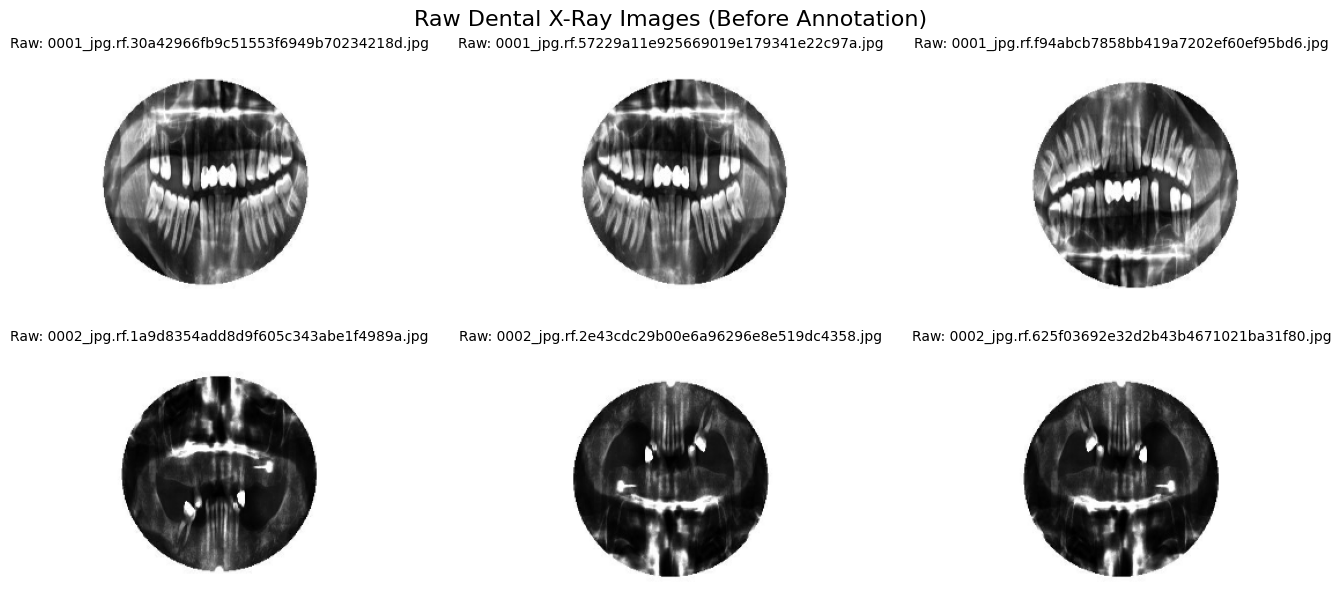


🔍 Visualizing Annotations (from Training Data):


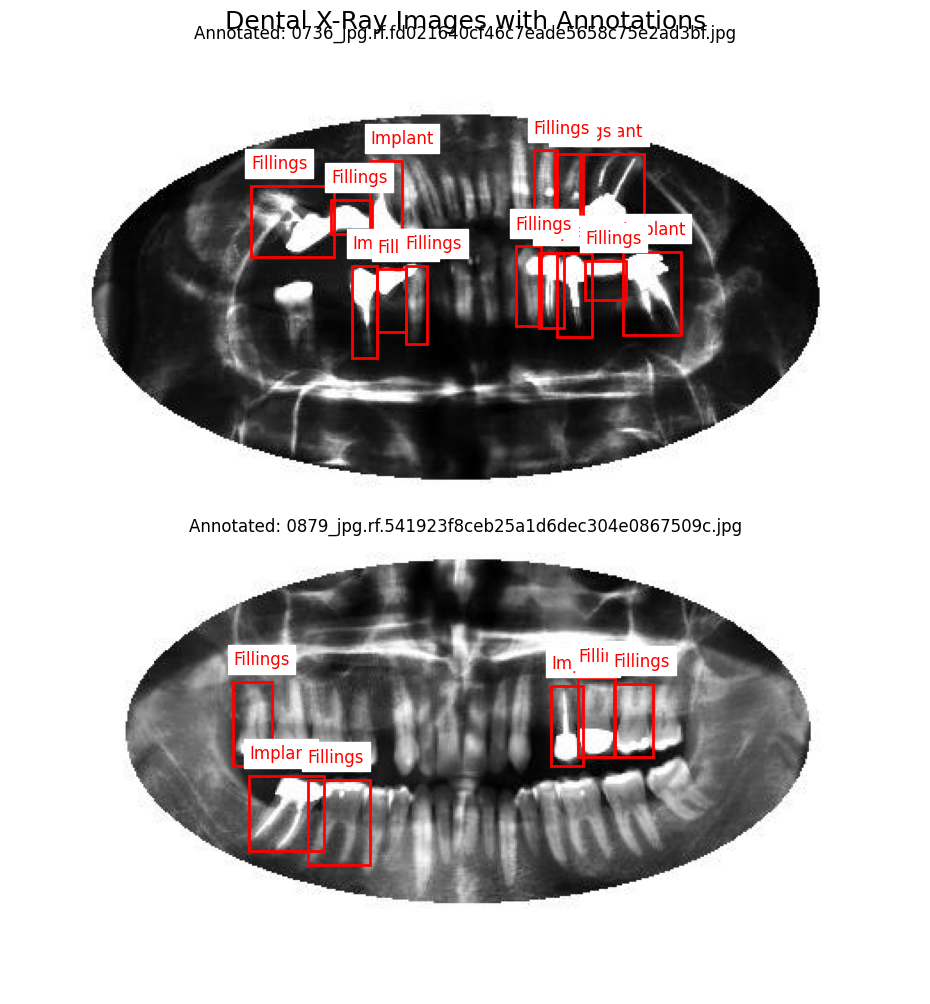

In [ ]:
# Function to plot raw images
def plot_raw_images(directory, num_images=6):
    image_files = [f for f in os.listdir(directory) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No images found in {directory}")
        return

    image_files = sorted(image_files)[:num_images]

    plt.figure(figsize=(15, 6))
    for idx, filename in enumerate(image_files):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE_RCT) # Resize for consistent display
            plt.subplot(2, num_images//2, idx+1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Raw: {filename}", fontsize=10)
            plt.axis('off')
        else:
            print(f"Error loading image: {filename}")
    plt.tight_layout()
    plt.suptitle("Raw Dental X-Ray Images (Before Annotation)", fontsize=16, y=1.02)
    plt.show()

# Function to visualize images with bounding box annotations
def visualize_annotations(image_dir, annotations_df, num_images=3):
    if annotations_df.empty or not os.path.exists(image_dir):
        print(f"Skipping annotation visualization for {image_dir} due to missing data or directory.")
        return

    unique_files = annotations_df['filename'].unique()
    # Ensure we don't try to sample more files than available
    selected_files = random.sample(list(unique_files), min(len(unique_files), num_images))

    plt.figure(figsize=(15, 5 * num_images))
    for i, filename in enumerate(selected_files):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path) # Load in BGR for OpenCV drawing
        if img is None:
            print(f"Could not load image for annotation: {img_path}")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        file_annotations = annotations_df[annotations_df['filename'] == filename]

        ax = plt.subplot(num_images, 1, i + 1)
        ax.imshow(img_rgb)
        ax.set_title(f"Annotated: {filename}")
        ax.axis('off')

        for idx, row in file_annotations.iterrows():
            # Ensure columns exist before accessing them
            if all(col in row for col in ['xmin', 'ymin', 'xmax', 'ymax', 'class']):
                xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
                label = row['class']

                # Draw bounding box
                rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                     fill=False, color='red', linewidth=2)
                ax.add_patch(rect)
                # Add label text
                ax.text(xmin, ymin - 10, label, color='red', fontsize=12, backgroundcolor='white')
            else:
                print(f"Missing annotation columns for file {filename} in row {idx}")
    plt.tight_layout()
    plt.suptitle("Dental X-Ray Images with Annotations", fontsize=18, y=1.00)
    plt.show()

# Call Visualizations for EDA
print("\n🖼️ Viewing Raw Images (from Training Directory):")
plot_raw_images(train_dir, num_images=6)

print("\n🔍 Visualizing Annotations (from Training Data):")
visualize_annotations(train_dir, train_annotations, num_images=2)

***🚨 Step 4: Anomaly Detection with Autoencoder***

This section implements an autoencoder to detect anomalies in the dental X-ray images. The autoencoder is trained on 'normal' images, and then reconstruction errors are used to identify potential anomalies.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)


Training Autoencoder...
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.1283 - val_loss: 0.0668
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0487 - val_loss: 0.0218
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0179 - val_loss: 0.0128
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0127 - val_loss: 0.0109
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0108 - val_loss: 0.0097
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0097 - val_loss: 0.0089
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0087 - val_loss: 0.0077
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 0.0079 - val_loss: 0.0069
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 0.0070 - val_loss: 0.0068
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0067 - val_loss: 0.0061


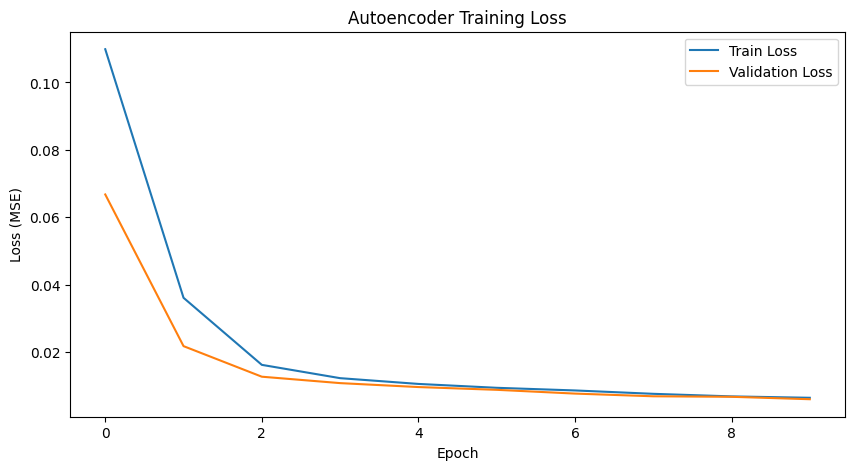


Generating anomaly maps...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


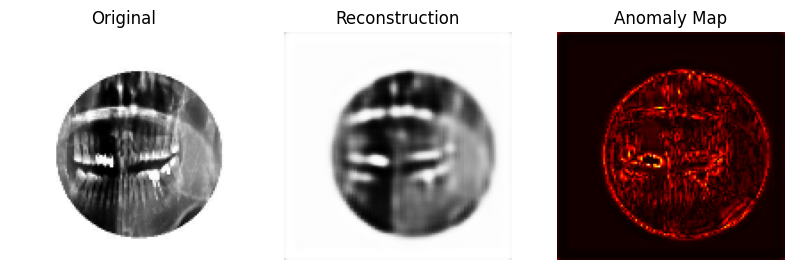

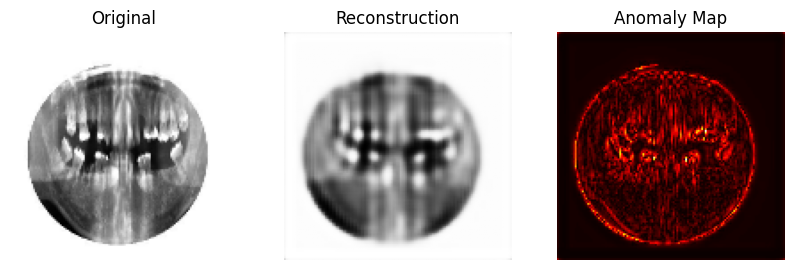

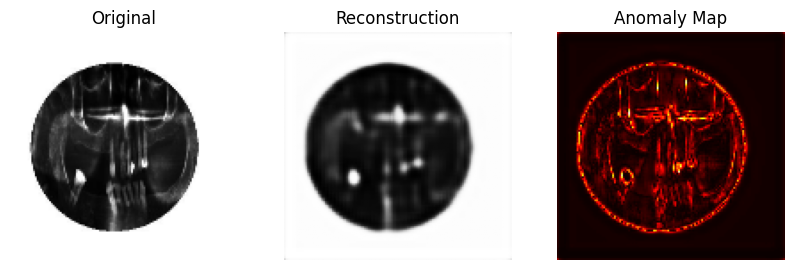

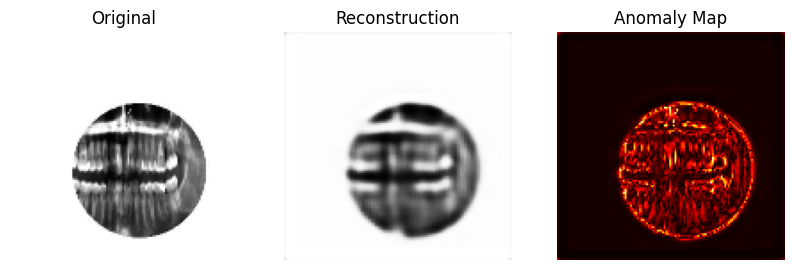

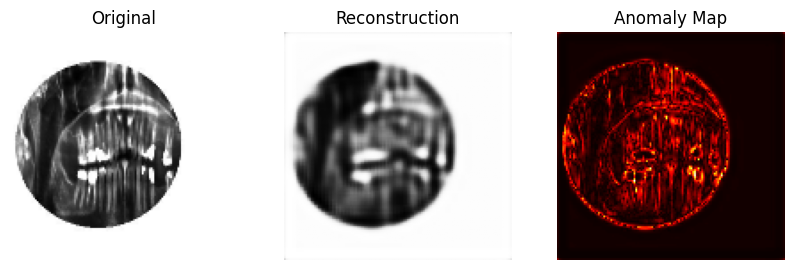

In [ ]:
# Build the Autoencoder model for Anomaly Detection
if train_images_ad.size > 0 and train_images_ad.shape[0] > 0:
    input_img = Input(shape=(IMG_SIZE_AD, IMG_SIZE_AD, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()

    # Train the Autoencoder
    print("\nTraining Autoencoder...")
    # Ensure train_images_ad has enough samples for validation split
    if train_images_ad.shape[0] >= 10: # At least 10 images for a 10% validation split to make sense
        history_ad = autoencoder.fit(train_images_ad, train_images_ad,
                                     epochs=10, # Reduced epochs for faster execution in combined notebook
                                     batch_size=32,
                                     validation_split=0.1,
                                     verbose=1) # Set verbose to 1 to see progress
    else:
        print("Not enough data for validation split. Training autoencoder without validation split.")
        history_ad = autoencoder.fit(train_images_ad, train_images_ad,
                                     epochs=10, # Reduced epochs for faster execution in combined notebook
                                     batch_size=32,
                                     verbose=1)


    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history_ad.history['loss'], label='Train Loss')
    if 'val_loss' in history_ad.history:
        plt.plot(history_ad.history['val_loss'], label='Validation Loss')
    plt.title('Autoencoder Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

    # Generate reconstructions and anomaly maps for test images
    if test_images_ad.size > 0 and test_images_ad.shape[0] > 0:
        print("\nGenerating anomaly maps...")
        decoded_imgs = autoencoder.predict(test_images_ad)

        for i in range(min(5, test_images_ad.shape[0])):
            plt.figure(figsize=(10, 3))

            # Original Image
            plt.subplot(1, 3, 1)
            plt.imshow(test_images_ad[i].squeeze(), cmap='gray')
            plt.title("Original")
            plt.axis('off')

            # Reconstructed Image
            plt.subplot(1, 3, 2)
            plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
            plt.title("Reconstruction")
            plt.axis('off')

            # Anomaly Map (Absolute Difference)
            plt.subplot(1, 3, 3)
            diff = np.abs(test_images_ad[i] - decoded_imgs[i])
            plt.imshow(diff.squeeze(), cmap='hot')
            plt.title("Anomaly Map")
            plt.axis('off')
            plt.show()
    else:
        print("No test images available for anomaly detection visualization.")
else:
    print("Skipping Anomaly Detection: No sufficient training images loaded.")

Training History and Anomaly Maps
This section shows the training progress of the Autoencoder and its ability to highlight anomalies in test images.

***🧪 Step 5: Randomized Controlled Trial (RCT) Analysis***

This section focuses on classifying dental X-ray images to determine the presence or absence of a root canal. A Convolutional Neural Network (CNN) is built, trained, and evaluated for this binary classification task.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)


Training RCT Classification Model...
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.8626 - loss: 0.6434 - val_accuracy: 0.9000 - val_loss: 0.3635
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.9034 - loss: 0.3368 - val_accuracy: 0.9000 - val_loss: 0.3274
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.8961 - loss: 0.3340 - val_accuracy: 0.9000 - val_loss: 0.3308
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.8721 - loss: 0.3885 - val_accuracy: 0.9000 - val_loss: 0.3674
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.9085 - loss: 0.3072 - val_accuracy: 0.9000 - val_loss: 0.3264
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.9021 - loss: 0.3193 - val_accuracy: 0.9000 - val_loss: 0.3199
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.9091 - loss: 0.3172 - val_accuracy: 0.9000 - val_loss: 0.3192
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.9031 - l

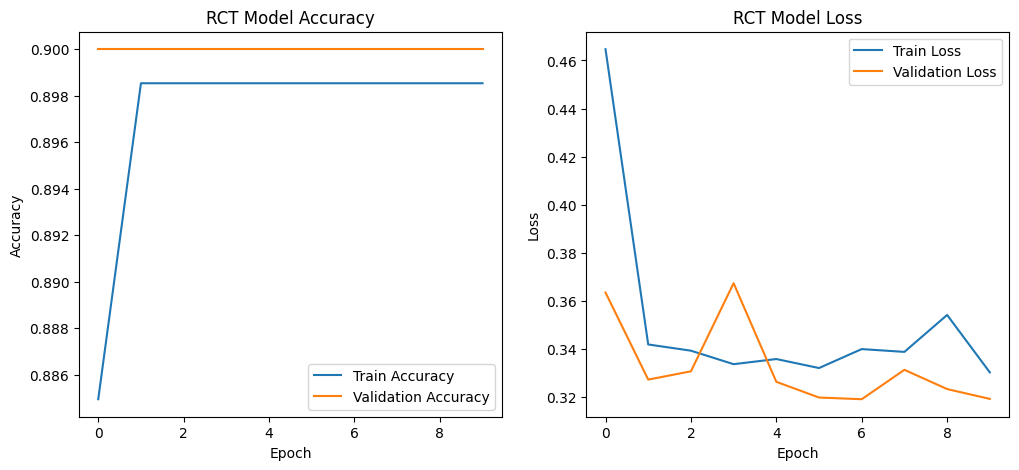


Evaluating RCT Model on Validation Data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 794ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.90      1.00      0.95       216

    accuracy                           0.90       240
   macro avg       0.45      0.50      0.47       240
weighted avg       0.81      0.90      0.85       240


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


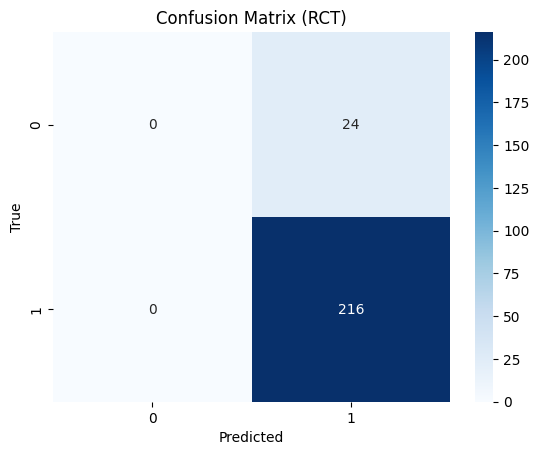

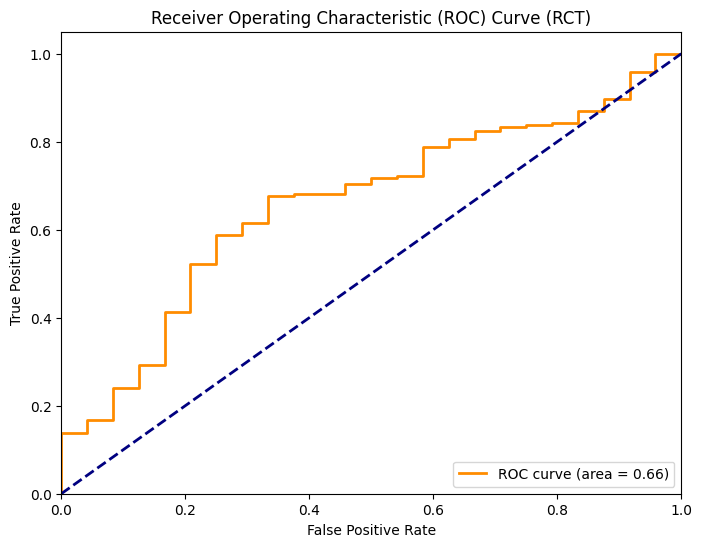

In [ ]:
# Build the CNN model for RCT analysis
if X_train_rct.size > 0 and X_train_rct.shape[0] > 0 and y_train_rct.size > 0:
    model_rct = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE_RCT[0], IMG_SIZE_RCT[1], 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model_rct.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model_rct.summary()

    # Callbacks for RCT model training
    callbacks_rct = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_rct_model.keras', save_best_only=True, monitor='val_loss')
    ]

    # Train the RCT model
    print("\nTraining RCT Classification Model...")
    history_rct = model_rct.fit(
        train_generator_rct,
        epochs=10, # Reduced epochs for faster execution in combined notebook
        validation_data=(X_val_rct, y_val_rct),
        callbacks=callbacks_rct,
        verbose=1 # Set verbose to 1 to see progress
    )

    # Plot training history for RCT model
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_rct.history['accuracy'], label='Train Accuracy')
    plt.plot(history_rct.history['val_accuracy'], label='Validation Accuracy')
    plt.title('RCT Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_rct.history['loss'], label='Train Loss')
    plt.plot(history_rct.history['val_loss'], label='Validation Loss')
    plt.title('RCT Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate the RCT model
    print("\nEvaluating RCT Model on Validation Data...")
    y_pred_rct = model_rct.predict(X_val_rct)
    y_pred_rct_binary = (y_pred_rct > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_val_rct, y_pred_rct_binary))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_val_rct, y_pred_rct_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (RCT)')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_val_rct, y_pred_rct)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (RCT)')
    plt.legend(loc="lower right")
    plt.show()

else:
    print("Skipping RCT Analysis: No RCT data loaded or prepared.")

***Prediction Time***

Predictions will not be accurate without a trained model.
Dummy model structure created.

--- Making Predictions on 10 Random Sample Test Images for Root Canal Classification ---
Attempting to predict on 10 random images from /content/dental-radiography/test.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


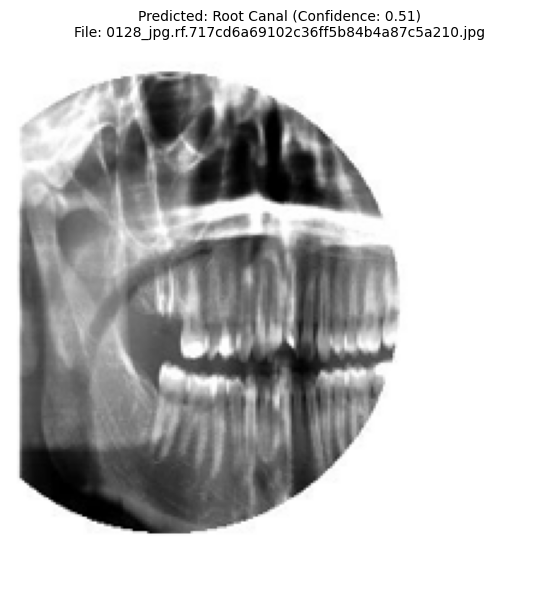

Image: 0128_jpg.rf.717cd6a69102c36ff5b84b4a87c5a210.jpg -> Predicted: Root Canal (Raw prediction score: 0.5112)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


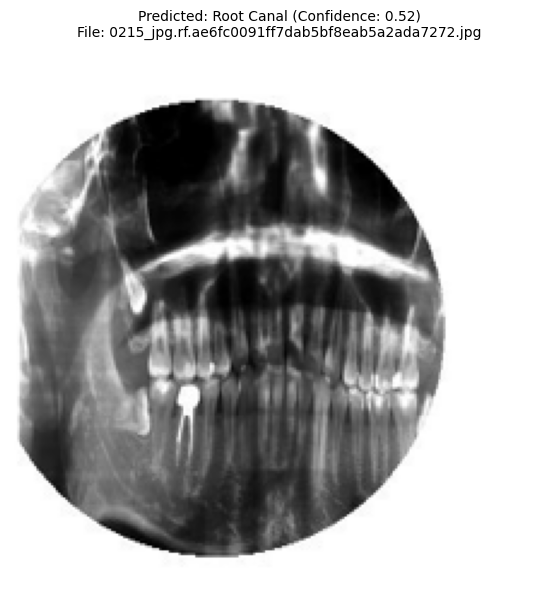

Image: 0215_jpg.rf.ae6fc0091ff7dab5bf8eab5a2ada7272.jpg -> Predicted: Root Canal (Raw prediction score: 0.5205)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


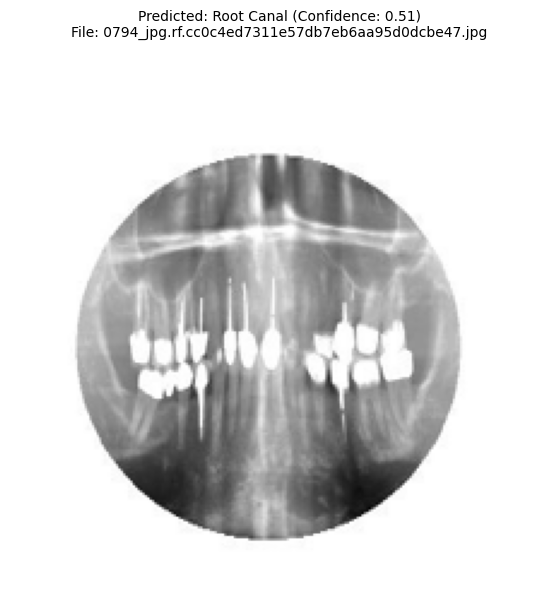

Image: 0794_jpg.rf.cc0c4ed7311e57db7eb6aa95d0dcbe47.jpg -> Predicted: Root Canal (Raw prediction score: 0.5123)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


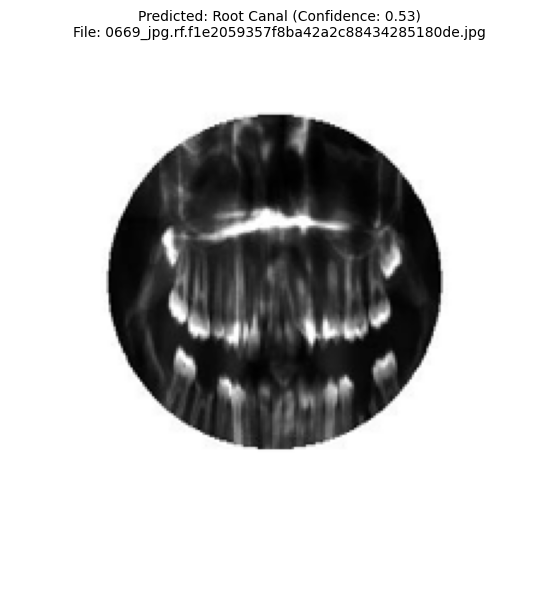

Image: 0669_jpg.rf.f1e2059357f8ba42a2c88434285180de.jpg -> Predicted: Root Canal (Raw prediction score: 0.5307)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


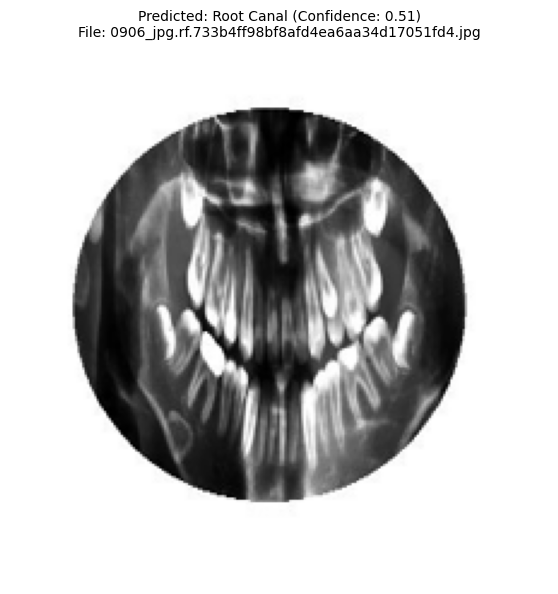

Image: 0906_jpg.rf.733b4ff98bf8afd4ea6aa34d17051fd4.jpg -> Predicted: Root Canal (Raw prediction score: 0.5095)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


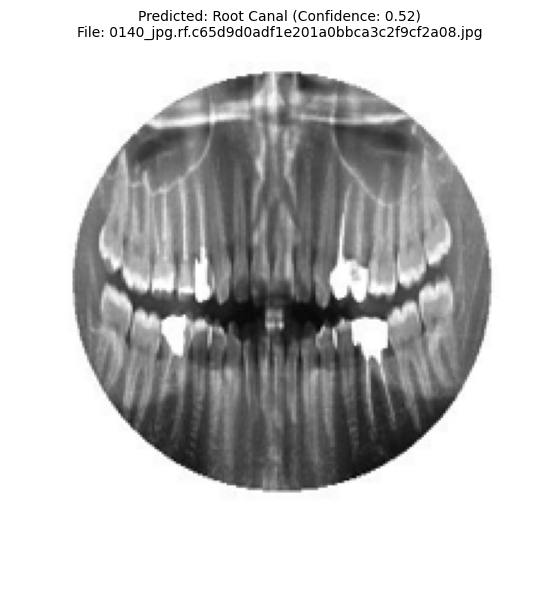

Image: 0140_jpg.rf.c65d9d0adf1e201a0bbca3c2f9cf2a08.jpg -> Predicted: Root Canal (Raw prediction score: 0.5161)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


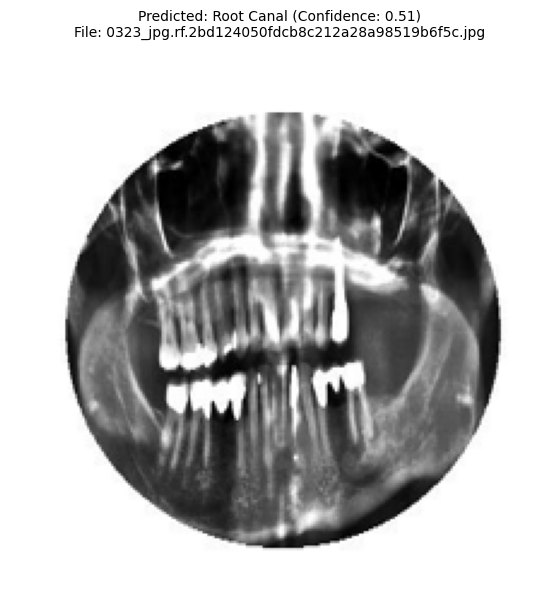

Image: 0323_jpg.rf.2bd124050fdcb8c212a28a98519b6f5c.jpg -> Predicted: Root Canal (Raw prediction score: 0.5106)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


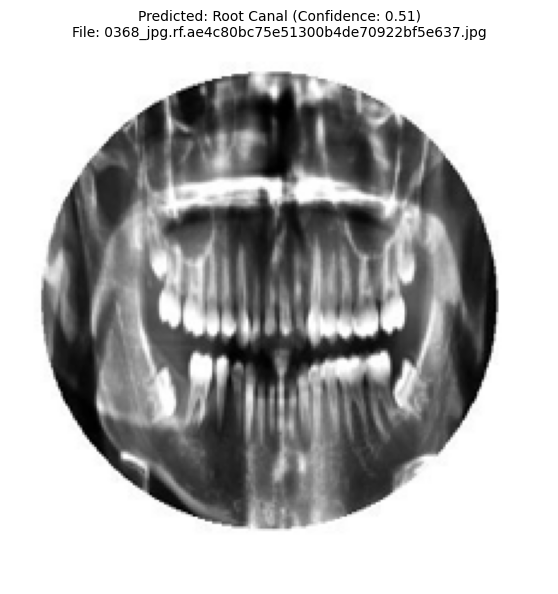

Image: 0368_jpg.rf.ae4c80bc75e51300b4de70922bf5e637.jpg -> Predicted: Root Canal (Raw prediction score: 0.5142)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


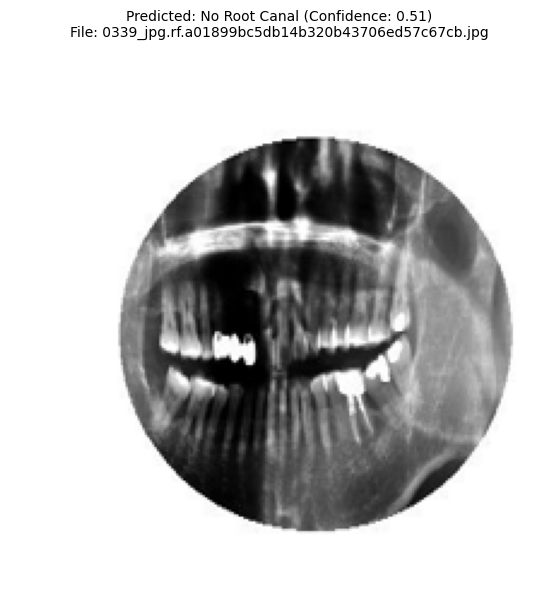

Image: 0339_jpg.rf.a01899bc5db14b320b43706ed57c67cb.jpg -> Predicted: No Root Canal (Raw prediction score: 0.4899)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


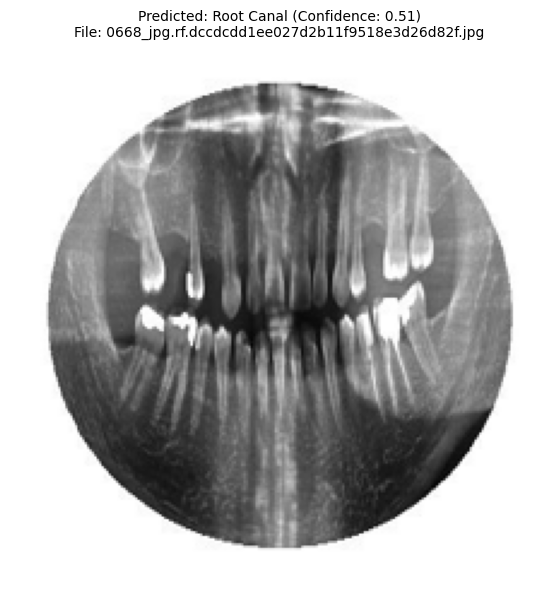

Image: 0668_jpg.rf.dccdcdd1ee027d2b11f9518e3d26d82f.jpg -> Predicted: Root Canal (Raw prediction score: 0.5131)

--- Prediction process complete ---


In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
import random
import matplotlib.pyplot as plt
# These imports are essential if this cell is run independently.
# In a full notebook, they might be imported earlier.
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam
from glob import glob # For robust file listing

# --- Define Constants (should be consistent with your training environment) ---
root_dir = '/content/dental-radiography'
test_dir = os.path.join(root_dir, 'test')
IMG_SIZE_RCT = (224, 224) # Image size used for RCT analysis

# --- Model Loading/Initialization ---
# IMPORTANT: For accurate predictions, ensure 'model_rct' is your trained model.
# If you run this cell in isolation, 'model_rct' might not be defined.
# In a real scenario, you would typically load your saved model like this:
# model_rct = tf.keras.models.load_model('best_rct_model.keras')
# Make sure 'best_rct_model.keras' is in your working directory or provide its full path.

# Dummy model creation for demonstration if no trained model is available.
# Remove this block if you are loading a pre-trained model.
model_rct = None # Initialize to None to check existence later
if 'model_rct' not in globals() or not isinstance(model_rct, (Sequential, Model)):
    print("Warning: 'model_rct' not found or not a Keras model. Creating a dummy model structure for demonstration.")
    print("Predictions will not be accurate without a trained model.")
    try:
        model_rct = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE_RCT[0], IMG_SIZE_RCT[1], 3)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')  # Binary classification
        ])
        model_rct.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
        print("Dummy model structure created.")
    except Exception as e:
        print(f"Error creating dummy model: {e}. Cannot proceed with predictions.")
        model_rct = None

print("\n--- Making Predictions on 10 Random Sample Test Images for Root Canal Classification ---")

if model_rct:
    all_test_files = []
    # Check if the test directory exists
    if os.path.exists(test_dir):
        # Use glob to find all image files (jpg, jpeg, png) in the test directory
        all_test_files.extend(glob(os.path.join(test_dir, '*.jpg')))
        all_test_files.extend(glob(os.path.join(test_dir, '*.jpeg')))
        all_test_files.extend(glob(os.path.join(test_dir, '*.png')))

        if len(all_test_files) > 0:
            # Select up to 10 random sample images
            num_samples_to_predict = min(10, len(all_test_files))
            sample_image_paths = random.sample(all_test_files, num_samples_to_predict)
            print(f"Attempting to predict on {num_samples_to_predict} random images from {test_dir}.")
        else:
            print(f"No image files found in {test_dir} for sampling.")
            sample_image_paths = [] # Ensure it's empty if no files
    else:
        print(f"Test directory not found at {test_dir}. Cannot load sample images for prediction.")
        sample_image_paths = [] # Ensure it's empty if directory not found

    if sample_image_paths:
        for img_path in sample_image_paths:
            img_filename = os.path.basename(img_path)
            try:
                # Load the image using PIL, convert to RGB, and resize
                img_pil = Image.open(img_path).convert('RGB').resize(IMG_SIZE_RCT)
                # Convert PIL image to NumPy array and normalize pixel values to [0, 1]
                img_array = np.array(img_pil) / 255.0
                # Add an extra dimension to represent the batch size (model expects [batch, height, width, channels])
                img_array = np.expand_dims(img_array, axis=0)

                # Make prediction using the loaded/dummy model
                # Ensure the model has been built (has weights) before predicting
                if model_rct.built: # 'built' attribute is true after model.fit or if weights are loaded
                    prediction = model_rct.predict(img_array)[0][0]

                    # Determine the predicted class based on a 0.5 threshold
                    predicted_class = "Root Canal" if prediction > 0.5 else "No Root Canal"
                    # Calculate confidence for display
                    confidence = prediction if prediction > 0.5 else (1 - prediction)

                    # Display the image with its prediction
                    plt.figure(figsize=(7, 7))
                    plt.imshow(img_pil) # Display the PIL image directly
                    plt.title(f"Predicted: {predicted_class} (Confidence: {confidence:.2f})\nFile: {img_filename}", fontsize=10)
                    plt.axis('off') # Hide axes for cleaner image display
                    plt.show()

                    print(f"Image: {img_filename} -> Predicted: {predicted_class} (Raw prediction score: {prediction:.4f})")
                else:
                    print(f"Skipping prediction for {img_filename}: Model has not been built or trained.")
            except Exception as e:
                print(f"Could not process sample image {img_filename} for prediction: {e}")
    else:
        print("No sample images were available or loaded for prediction.")
else:
    print("RCT classification model is not available. Please ensure it is trained or loaded before attempting predictions.")

print("\n--- Prediction process complete ---")